In [4]:
# Import necessary modules
import glob
import json
import numpy as np
import math
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import subprocess
import sys

from datetime import datetime, timedelta
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle, Circle
from mpl_toolkits.mplot3d import Axes3D

## Helper functions

In [62]:
# General plotting function for hourly-defined variables 
# (e.g. temperature, humidity, fertilizer, irrigation, plant height, leaf area, number of leaves, flower size, fruit biomass)
def plotter(
        variable,          # Numpy array of hourly variable values
        variable_name=None # Variable name for the plot
    ):
    plt.figure(figsize=(10, 5))
    x_vals = np.arange(len(variable))
    
    # Plot the original variable
    plt.plot(x_vals, variable, color='green', linewidth=3)
    
    # Compute half of the maximum value
    half_max = 0.5 * np.max(variable)
    
    # Find where variable is approximately equal to half the max (within tolerance)
    tolerance = 0.001  # adjust if needed
    half_max_indices = np.where(np.isclose(variable, half_max, atol=tolerance))[0]
    
    # Plot red dots and annotate
    for idx in half_max_indices:
        plt.plot(idx, variable[idx], 'ro')  # red dot
        plt.annotate(f'x = {idx}', (idx, variable[idx]), textcoords="offset points", xytext=(0,10), ha='center', color='red')

    plt.xlabel('Hours')
    plt.ylabel(f'{variable_name if variable_name else "Variable"}')
    plt.title(f'{variable_name} over Time' if variable_name else 'Variable over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [45]:
def richards_growth(
        Tsim, # Total simulation time
        k,    # Carrying capacity
        a,    # Growth rate
        nu,   # Shape parameter
        N0    # Initial size
    ):
    N = N0 * np.ones_like(np.arange(Tsim))
    for t in range(1, Tsim):
        N[t] = k * (1 + ( ( k/N0 )**nu - 1 ) * np.exp( -nu * a * t ) )**( -1/nu )
    return N

## Find values for the growth rates that make sense

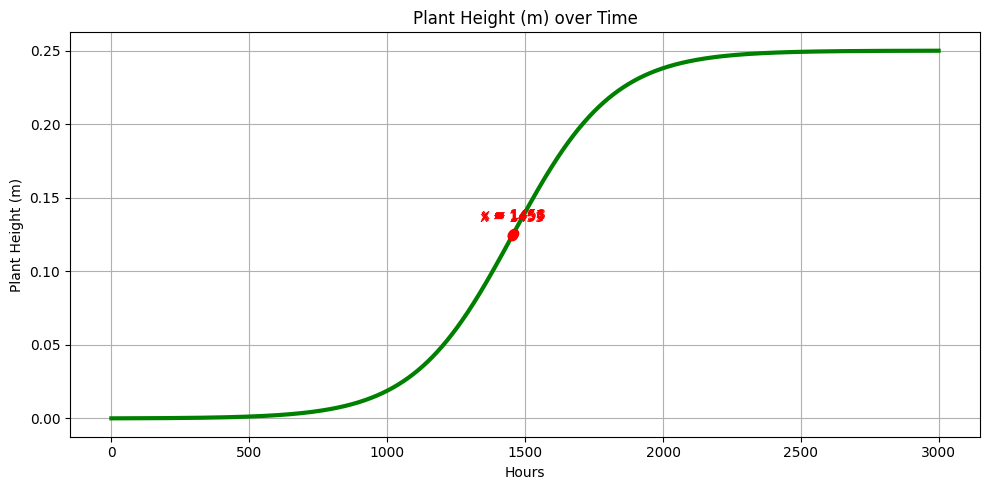

In [64]:
# Fruit biomass
kP = 0.25     # kg
P0 = kP/3000  # kg/hr
aP = 0.0055     # 1/hr

P = richards_growth(
    Tsim=3000,     
    k=kP,
    a=aP,
    nu=1,
    N0=P0
)
# Plot plant height
plotter(
    variable=P, 
    variable_name='Plant Height (m)'
)

In [22]:
# Richards Growth ?

# Plant height constants
kh = 3.0     # m
h0 = kh/3000 # m/hr
ah = 0.01    # 1/hr

# Leaf area
kA = 0.65    # m2
A0 = kA/3000 # m2/hr
aA = 0.005   # 1/hr

# Number of leaves
kN = 20      # number of leaves
N0 = kN/3000 # number/hr
aN = 0.0105  # 1/hr

# Flower size
kc = 1000     # number of spikelets
c0 = kc/3000  # number/hr
ac = 0.01     # 1/hr

# Fruit biomass
kP = 0.25     # kg
P0 = kP/3000  # kg/hr
aP = 0.0055   # 1/hr

# Simulation settings
dt = 1 # hour
Tsim = 2400 # hours

# Note for later: Richard's growth as an alternative to logistic growth?

In [3]:
# Initialize storage variables
h = h0 * np.ones(Tsim)
A = A0 * np.ones(Tsim)
P = P0 * np.ones(Tsim)

WCs = np.zeros(Tsim)
FCs = np.zeros(Tsim)
TCs = np.zeros(Tsim)

In [4]:
# Hourly irrigation, fertilizer, and temperature
hourly_df = pd.read_csv('hourly_temp_water_fertilizer.csv')
hourly_temp = hourly_df['Hourly Temperatures']
hourly_water = hourly_df['Hourly Water Consumption']
hourly_fert = hourly_df['Hourly Fertilizer Consumption']

Agricultural crop growth
→ Plant size/mass vs. time — crops grow slower early on and saturate at different rates.

Forestry
→ Tree and biomass growth (widely used in forest modeling).

In [5]:
# Run Simulation
for t in range(Tsim-1):

   if t%24 == 0:
      print(f'Day {int(t/24)} of {int(Tsim/24)}')

   # Read-in water, fertilzier, and temperature at this time step
   W = hourly_water[t]
   F = hourly_fert[t]
   T = hourly_temp[t]

   # Update cumulative values
   WC = WCs[t] + W
   WCs[t+1] = WC

   FC = FCs[t] + F
   FCs[t+1] = FC

   TC = TCs[t] + T
   TCs[t+1] = TC

   # Height update
   ahW = GhW * 1/np.sqrt(2 * sigmaW**2) * np.exp(-(WC - muW)**2 / sigmaW**2)
   ahF = GhF * 1/np.sqrt(2 * sigmaF**2) * np.exp(-(FC - muF)**2 / sigmaF**2)
   ahT = GhT * 1/np.sqrt(2 * sigmaT**2) * np.exp(-(TC - muT)**2 / sigmaT**2)

   ah = ahW + ahF + ahT
   #dhdt = ah * h[t] * (1 - h[t]/kh)       # Logistic growth 
   dhdt = ah * h[t] * (1 - (h[t]/kh)**nuh) # Richards growth 
   #dhdt = ah * h[t] * np.log(kh/h[t]) # Gompertz growth 
   h[t+1] = h[t] + dt * dhdt 

   # Area update
   #dAdh = aA * A[t] * (1 - A[t]/kA) # Logisitc growth
   dAdh = aA * 10000 * A[t] * (1 - (A[t]/kA)**nuA) # Ricahrds growth
   #dAdh = aA * ah * A[t] * np.log(kA/A[t]) # Gompertz growth
   dAdt = dAdh * dhdt
   A[t+1] = A[t] + dt * dAdt

   if t%24 == 0:
      print(f'aA = {aA*10}')
      print(f'dhdt/kh = {dhdt/kh}')
      print(f'dAdt/kA = {dAdt/kA}')

   # Fruit Biomass update
   dPdc = aP * P[t] * (1 - P[t]/kP)
   dcdA = 128/np.pi * rhoL/aN * 1/np.sqrt(A[t]**3)
   dPdt = dPdc * dcdA * dAdt
   P[t+1] = P[t] + dt * dPdt

Day 0 of 100
aA = 0.04
dhdt/kh = 4.412836115247884e-06
dAdt/kA = 3.177242002978477e-06
Day 1 of 100
aA = 0.04
dhdt/kh = 5.086233384719985e-06
dAdt/kA = 3.6904482610263295e-06
Day 2 of 100
aA = 0.04
dhdt/kh = 5.880219665785266e-06
dAdt/kA = 4.3047752660458005e-06
Day 3 of 100
aA = 0.04
dhdt/kh = 6.702834323408249e-06
dAdt/kA = 4.957371052550683e-06
Day 4 of 100
aA = 0.04
dhdt/kh = 7.788409424488286e-06
dAdt/kA = 5.828080526587993e-06
Day 5 of 100
aA = 0.04
dhdt/kh = 9.160406004766393e-06
dAdt/kA = 6.9494384518393814e-06
Day 6 of 100
aA = 0.04
dhdt/kh = 1.0525287262368162e-05
dAdt/kA = 8.1130225629734e-06
Day 7 of 100
aA = 0.04
dhdt/kh = 1.2037779817220743e-05
dAdt/kA = 9.449603530523997e-06
Day 8 of 100
aA = 0.04
dhdt/kh = 1.389945781549898e-05
dAdt/kA = 1.1140633335867212e-05
Day 9 of 100
aA = 0.04
dhdt/kh = 1.617863833275983e-05
dAdt/kA = 1.328433765975295e-05
Day 10 of 100
aA = 0.04
dhdt/kh = 1.884116924180409e-05
dAdt/kA = 1.5910684339935934e-05
Day 11 of 100
aA = 0.04
dhdt/kh = 2.2

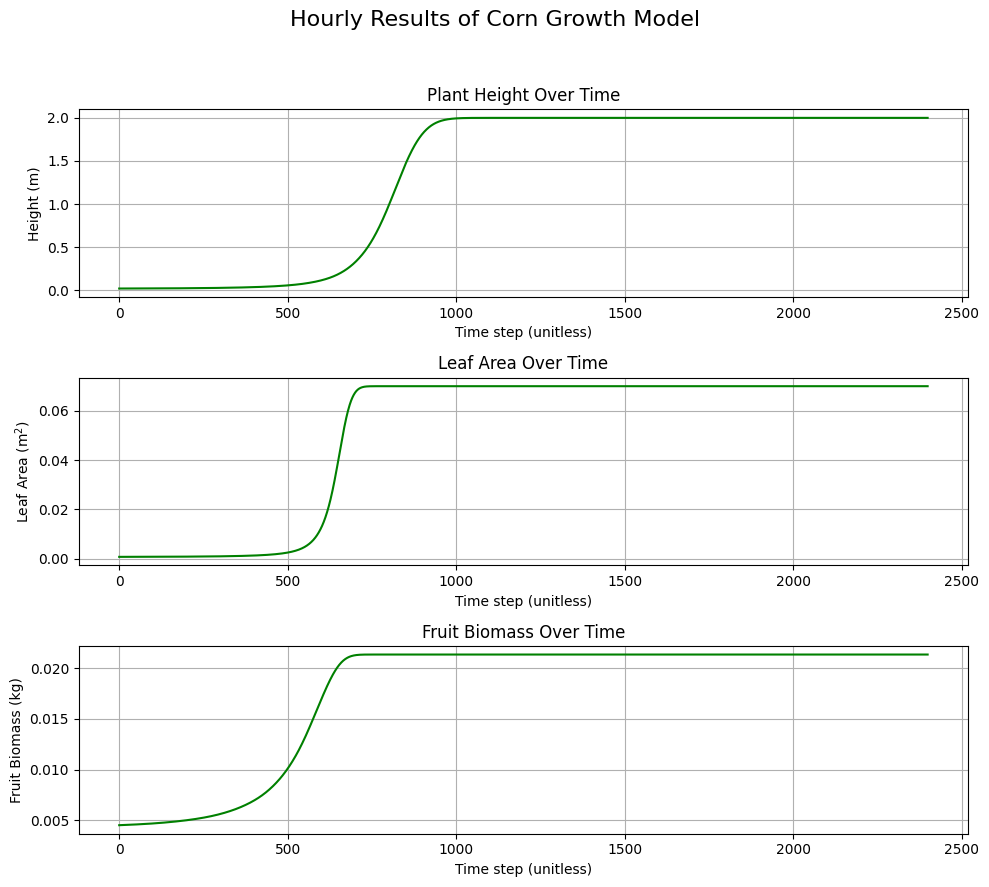

In [6]:
# Plot the time-dependent variables

fig, axs = plt.subplots(3, 1, figsize=(10, 9))

# Height
axs[0].plot(np.arange(Tsim), h, color='green')
axs[0].set_xlabel('Time step (unitless)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title(f'Plant Height Over Time')
axs[0].grid(True)

# Leaf Area
axs[1].plot(np.arange(Tsim), A, color='green')
axs[1].set_xlabel('Time step (unitless)')
axs[1].set_ylabel(r'Leaf Area (m$^{2}$)')
axs[1].set_title(f'Leaf Area Over Time')
axs[1].grid(True)

# Fruit Biomass
axs[2].plot(np.arange(Tsim), P, color='green')
axs[2].set_xlabel('Time step (unitless)')
axs[2].set_ylabel('Fruit Biomass (kg)')
axs[2].set_title(f'Fruit Biomass Over Time')
axs[2].grid(True)

fig.suptitle(f'Hourly Results of Corn Growth Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent overlap
plt.show()